<a href="https://colab.research.google.com/github/maxaragon/UBS/blob/main/MAX_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author:** Max Aragón <br>
**Professor:** Minh-Tan Pham<br>
**Affiliations:** Université Bretagne Sud<br>
**Course:** Image processing / Deep learning <br>
**Date:** 2022-12-12

<div class="alert alert-block alert-success">
<h2><center>Transfer Learning for Computer Vision</center></h2>

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.


In [8]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.models import ResNet18_Weights, SqueezeNet1_1_Weights, AlexNet_Weights, VGG11_BN_Weights
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import copy
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd drive/MyDrive/Colab_Notebooks/Data

In [12]:
!nvidia-smi -L

GPU 0: A100-SXM4-40GB (UUID: GPU-29a76f4e-a9e1-e408-f9d4-cd576d552e27)


In [13]:
!ls 'UCMerced'

test  train  val


In [22]:
def count_files(subdirectory):
    # initialize the counter
    num_files = 0

    # traverse the directory tree and get a list of all files
    for root, directories, files in os.walk(subdirectory):
        # get a list of hidden files in the directory
        hidden_files = glob.glob(os.path.join(root, '.*'))

        # add the number of hidden files to the counter
        num_files += len(hidden_files)

        # add the number of regular files to the counter
        num_files += len(files)

    # return the result
    return num_files

In [23]:
print('UC Merced')
total_files = count_files('UCMerced'); print(f'Total number of images: {total_files}')
train_files = count_files('UCMerced/train'); print(f'Training set size: {train_files}')
val_files = count_files('UCMerced/val'); print(f'Validation set size: {val_files}')
test_files = count_files('UCMerced/test'); print(f'Test set size: {test_files}')

UC Merced
Total number of images: 2100
Training set size: 1050
Validation set size: 630
Test set size: 420


In [24]:
print('EuroSAT')
total_files = count_files('EuroSAT'); print(f'Total number of images: {total_files}')
train_files = count_files('EuroSAT/train'); print(f'Training set size: {train_files}')
val_files = count_files('EuroSAT/val'); print(f'Validation set size: {val_files}')
test_files = count_files('EuroSAT/test'); print(f'Test set size: {test_files}')

EuroSAT
Total number of images: 27000
Training set size: 13500
Validation set size: 8100
Test set size: 5400


In [25]:
def dataloading(data_dir, batch_size=4):
    '''
    Data augmentation and normalization for training and only normalization for validation and test
    '''
    data_transforms = {
      'train': transforms.Compose([
          transforms.RandomResizedCrop(224),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
      'val': transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
      'test': transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
       ]),
    }

    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'val', 'test']}
    
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
    
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']} 
    
    class_names = image_datasets['train'].classes
          
    return image_datasets, dataloaders, dataset_sizes, class_names

# Verify GPU availability

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu'); device

device(type='cuda', index=0)

### Visualize a few images

In [27]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# UC Merced preview

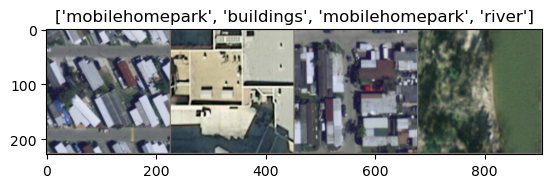

In [ ]:
image_datasets, dataloaders_merced, dataset_sizes, class_names = dataloading(data_dir='UCMerced', batch_size=4)

# Get a batch of training data
inputs, classes = next(iter(dataloaders_merced['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# EuroSAT preview

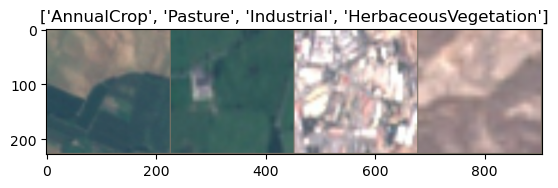

In [ ]:
image_datasets, dataloaders_eurosat, dataset_sizes, class_names = dataloading(data_dir='EuroSAT', batch_size=4)

# Get a batch of training data
inputs, classes = next(iter(dataloaders_eurosat['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Model functions

In [28]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            #epoch_acc = running_corrects.float() / dataset_sizes[phase]


            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    time_total = f'{time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s'
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, time_total 

In [29]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [30]:
def parameters(model):
    total_params = 0
    for name, parameter in model_ft.named_parameters():
            if not parameter.requires_grad: continue
            param = parameter.numel()
            total_params+=param
    return total_params

In [31]:
def performance(model, test_set):
    model.eval()

    # Create a metric to track accuracy
    accuracy = 0

    # Iterate over the data
    for data, labels in test_set:
        data = data.to(device)
        labels = labels.to(device)
        # Use with torch.no_grad() to evaluate the model
        with torch.no_grad():
            # Forward pass
            output = model(data)

        # Compute accuracy
        pred = output.argmax(dim=1)
        correct = pred.eq(labels.view_as(pred))
        accuracy += correct.sum()
        
    performance = accuracy / len(test_set.dataset)
    model_performance = round(performance.item(),5)
    return model_performance

In [32]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [33]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        if use_pretrained == False:
            model_ft = models.resnet18(weights=None)
        else:
            model_ft = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        if use_pretrained == False:
            model_ft = models.alexnet(weights=None)
        else:
            model_ft = models.alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        if use_pretrained == False:
            model_ft = models.vgg11_bn(weights=None)
        else:
            model_ft = models.vgg11_bn(weights=VGG11_BN_Weights.IMAGENET1K_V1)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        if use_pretrained == False:
            model_ft = models.squeezenet1_1(weights=None)
        else:
            model_ft = models.squeezenet1_1(weights=SqueezeNet1_1_Weights.IMAGENET1K_V1)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        if use_pretrained == False:
            model_ft = models.densenet121(weights=None)
        else: 
            model_ft = models.densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        if use_pretrained == False:
            model_ft = models.inception_v3(weights=None)
        else:
            model_ft = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

In [34]:
def initialize_mode(mode):
    if mode == 'FS':
        feature_extract = False
        use_pretrained = False
    elif mode == 'FT':
        feature_extract = False
        use_pretrained = True
    elif mode == 'FE':
        feature_extract = True
        use_pretrained = True
        
    return feature_extract, use_pretrained

In [35]:
def plot_models(SQN, AXN, VGG, num_epochs, title):             
    SQ = [h.cpu().numpy() for h in SQN]
    AN = [h.cpu().numpy() for h in AXN]
    VG = [h.cpu().numpy() for h in VGG]

    plt.title(title)
    plt.xlabel("Training Epochs")
    plt.ylabel("Validation Accuracy")
    plt.plot(range(1,num_epochs+1), SQ, label='Squeezenet')
    plt.plot(range(1,num_epochs+1), AN, label='Alexnet')
    plt.plot(range(1,num_epochs+1), VG, label='VGG')
    plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()

# UC Merced

In [ ]:
# Data dir, classes, batches and epochs

data_dir = 'UCMerced'

# Number of classes in the dataset
num_classes = 21

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Data loading
image_datasets, dataloaders, dataset_sizes, class_names = dataloading(data_dir=data_dir, batch_size=batch_size)

test_set = dataloaders['test']

num_epochs = 25

modes = ['FS', 'FT', 'FE']

model_list = ['squeezenet', 'alexnet', 'vgg']

results = pd.DataFrame(columns=["Mode", "Model", "Accuracy", "Parameters", "Time"])

In [ ]:
train_size = len(dataloaders['train']); print(f'Training set size: {train_size}')
val_size = len(dataloaders['val']); print(f'Validation set size: {val_size}')
test_size = len(dataloaders['test']); print(f'Test set size: {test_size}')
total_size = train_size + val_size + test_size; print(f'Total: {total_size}')

Training set size: 33
Validation set size: 20
Test set size: 14
Total: 67


--------------------------------------------------
                   FROM SCRATCH                   
--------------------------------------------------
squeezenet
----------
Epoch 0/24
----------
train Loss: 3.0498 Acc: 0.0467
val Loss: 3.0364 Acc: 0.0476

Epoch 1/24
----------
train Loss: 3.0347 Acc: 0.0410
val Loss: 3.0158 Acc: 0.0476

Epoch 2/24
----------
train Loss: 3.0177 Acc: 0.0524
val Loss: 3.0036 Acc: 0.0476

Epoch 3/24
----------
train Loss: 2.9801 Acc: 0.0695
val Loss: 2.9099 Acc: 0.1095

Epoch 4/24
----------
train Loss: 2.8962 Acc: 0.0952
val Loss: 2.9077 Acc: 0.0984

Epoch 5/24
----------
train Loss: 2.8893 Acc: 0.1124
val Loss: 2.8356 Acc: 0.0937

Epoch 6/24
----------
train Loss: 2.8325 Acc: 0.1219
val Loss: 2.8455 Acc: 0.0921

Epoch 7/24
----------
train Loss: 2.8019 Acc: 0.1229
val Loss: 2.7402 Acc: 0.1317

Epoch 8/24
----------
train Loss: 2.7562 Acc: 0.1495
val Loss: 2.7164 Acc: 0.1413

Epoch 9/24
----------
train Loss: 2.7398 Acc: 0.1514
val Loss: 2.7303 Acc: 0.1

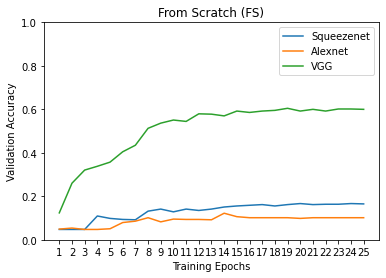

--------------------------------------------------
                    FINETUNING                    
--------------------------------------------------
squeezenet
----------


Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


  0%|          | 0.00/4.73M [00:00<?, ?B/s]

Epoch 0/24
----------
train Loss: 2.4679 Acc: 0.2733
val Loss: 1.7300 Acc: 0.4730

Epoch 1/24
----------
train Loss: 1.7243 Acc: 0.4762
val Loss: 1.3800 Acc: 0.5635

Epoch 2/24
----------
train Loss: 1.3322 Acc: 0.5819
val Loss: 1.1292 Acc: 0.6460

Epoch 3/24
----------
train Loss: 1.1227 Acc: 0.6638
val Loss: 1.0092 Acc: 0.6778

Epoch 4/24
----------
train Loss: 0.9420 Acc: 0.7000
val Loss: 0.5362 Acc: 0.8270

Epoch 5/24
----------
train Loss: 0.8255 Acc: 0.7419
val Loss: 0.5474 Acc: 0.8175

Epoch 6/24
----------
train Loss: 0.7253 Acc: 0.7610
val Loss: 0.4894 Acc: 0.8365

Epoch 7/24
----------
train Loss: 0.4256 Acc: 0.8571
val Loss: 0.3215 Acc: 0.8857

Epoch 8/24
----------
train Loss: 0.2955 Acc: 0.9114
val Loss: 0.2673 Acc: 0.9175

Epoch 9/24
----------
train Loss: 0.2775 Acc: 0.9114
val Loss: 0.2768 Acc: 0.9143

Epoch 10/24
----------
train Loss: 0.2477 Acc: 0.9124
val Loss: 0.2483 Acc: 0.9190

Epoch 11/24
----------
train Loss: 0.2672 Acc: 0.9190
val Loss: 0.2601 Acc: 0.9111

Ep

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Epoch 0/24
----------
train Loss: 1.5760 Acc: 0.5371
val Loss: 0.8817 Acc: 0.6984

Epoch 1/24
----------
train Loss: 1.1574 Acc: 0.6390
val Loss: 0.9409 Acc: 0.7254

Epoch 2/24
----------
train Loss: 0.9062 Acc: 0.7162
val Loss: 0.5556 Acc: 0.8175

Epoch 3/24
----------
train Loss: 0.8015 Acc: 0.7552
val Loss: 0.5648 Acc: 0.8302

Epoch 4/24
----------
train Loss: 0.7307 Acc: 0.7667
val Loss: 0.5806 Acc: 0.8222

Epoch 5/24
----------
train Loss: 0.7008 Acc: 0.7800
val Loss: 0.4321 Acc: 0.8651

Epoch 6/24
----------
train Loss: 0.5984 Acc: 0.8114
val Loss: 0.3377 Acc: 0.8810

Epoch 7/24
----------
train Loss: 0.3931 Acc: 0.8733
val Loss: 0.2554 Acc: 0.9159

Epoch 8/24
----------
train Loss: 0.2880 Acc: 0.9143
val Loss: 0.2081 Acc: 0.9333

Epoch 9/24
----------
train Loss: 0.2853 Acc: 0.9143
val Loss: 0.2031 Acc: 0.9286

Epoch 10/24
----------
train Loss: 0.2302 Acc: 0.9257
val Loss: 0.2099 Acc: 0.9238

Epoch 11/24
----------
train Loss: 0.2069 Acc: 0.9381
val Loss: 0.2056 Acc: 0.9222

Ep

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

Epoch 0/24
----------
train Loss: 1.6845 Acc: 0.5114
val Loss: 0.5222 Acc: 0.8175

Epoch 1/24
----------
train Loss: 0.5856 Acc: 0.8105
val Loss: 0.7232 Acc: 0.8111

Epoch 2/24
----------
train Loss: 0.4855 Acc: 0.8505
val Loss: 0.3601 Acc: 0.8714

Epoch 3/24
----------
train Loss: 0.3320 Acc: 0.9029
val Loss: 0.2187 Acc: 0.9381

Epoch 4/24
----------
train Loss: 0.2825 Acc: 0.9067
val Loss: 0.2254 Acc: 0.9349

Epoch 5/24
----------
train Loss: 0.2491 Acc: 0.9286
val Loss: 0.2166 Acc: 0.9286

Epoch 6/24
----------
train Loss: 0.2549 Acc: 0.9229
val Loss: 0.1574 Acc: 0.9444

Epoch 7/24
----------
train Loss: 0.2106 Acc: 0.9410
val Loss: 0.1176 Acc: 0.9619

Epoch 8/24
----------
train Loss: 0.1663 Acc: 0.9543
val Loss: 0.1124 Acc: 0.9651

Epoch 9/24
----------
train Loss: 0.1838 Acc: 0.9410
val Loss: 0.1052 Acc: 0.9651

Epoch 10/24
----------
train Loss: 0.1270 Acc: 0.9619
val Loss: 0.1059 Acc: 0.9698

Epoch 11/24
----------
train Loss: 0.1316 Acc: 0.9667
val Loss: 0.0884 Acc: 0.9762

Ep

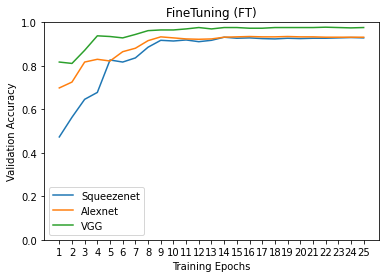

--------------------------------------------------
                FEATURE EXTRACTION                
--------------------------------------------------
squeezenet
----------
Epoch 0/24
----------
train Loss: 1.7702 Acc: 0.4905
val Loss: 1.1933 Acc: 0.7286

Epoch 1/24
----------
train Loss: 0.8058 Acc: 0.7457
val Loss: 0.5197 Acc: 0.8365

Epoch 2/24
----------
train Loss: 0.5396 Acc: 0.8324
val Loss: 0.4002 Acc: 0.8746

Epoch 3/24
----------
train Loss: 0.4162 Acc: 0.8743
val Loss: 0.3357 Acc: 0.8873

Epoch 4/24
----------
train Loss: 0.3702 Acc: 0.8752
val Loss: 0.2946 Acc: 0.9095

Epoch 5/24
----------
train Loss: 0.3656 Acc: 0.8876
val Loss: 0.2550 Acc: 0.9143

Epoch 6/24
----------
train Loss: 0.3133 Acc: 0.9000
val Loss: 0.3912 Acc: 0.8873

Epoch 7/24
----------
train Loss: 0.3019 Acc: 0.9114
val Loss: 0.2076 Acc: 0.9365

Epoch 8/24
----------
train Loss: 0.2231 Acc: 0.9305
val Loss: 0.2003 Acc: 0.9333

Epoch 9/24
----------
train Loss: 0.2115 Acc: 0.9381
val Loss: 0.1994 Acc: 0.9

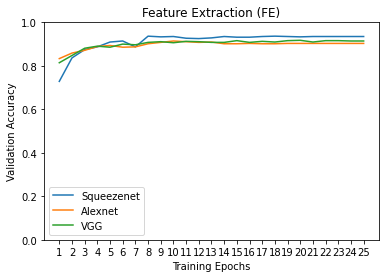

In [ ]:
for mode in modes:
    feature_extract, use_pretrained = initialize_mode(mode)
    print('-' * 50)
    if mode == 'FS':
        print('{:^50}'.format('FROM SCRATCH'))
    elif mode == 'FT':
        print('{:^50}'.format('FINETUNING'))
    elif mode == 'FE':
        print('{:^50}'.format('FEATURE EXTRACTION'))
    print('-' * 50)
    
    SQN = []
    AXN = []
    VGG = []
        
    for m in model_list:
        print(m)
        print('-' * 10)
        model_ft, input_size = initialize_model(m, num_classes, feature_extract, use_pretrained)
        model_ft = model_ft.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.005, momentum=0.9)
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
        model_out, val_acc_history, time_elapsed = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)
        total_params = parameters(model_out);
        model_performance = performance(model_out, test_set); 
        print(f'Model: {m}, accuracy: {model_performance}, time: {time_elapsed}, params: {total_params}')
        print('-' * 10)
        if m == 'squeezenet':
            SQN.extend(val_acc_history)
        elif m == 'alexnet':
            AXN.extend(val_acc_history)
        elif m == 'vgg':
            VGG.extend(val_acc_history)
        
        new_row = pd.DataFrame({"Mode": mode, "Model": m, "Accuracy": model_performance, "Parameters": total_params, "Time": time_elapsed}, index=[0])
        results = pd.concat([results, new_row], ignore_index=True)


    if mode == 'FS':
        plot_models(SQN, AXN, VGG, num_epochs, title='From Scratch (FS)')
    
    elif mode == 'FT':
        plot_models(SQN, AXN, VGG, num_epochs, title='FineTuning (FT)')
    
    elif mode == 'FE':
        plot_models(SQN, AXN, VGG, num_epochs, title='Feature Extraction (FE)')

# Results UC Merced

In [ ]:
results

,Mode,Model,Accuracy,Parameters,Time
0,FS,squeezenet,0.15476,733269,1m 15s
1,FS,alexnet,0.09762,57089877,1m 10s
2,FS,vgg,0.59524,128857877,1m 27s
3,FT,squeezenet,0.91190,733269,1m 12s
4,FT,alexnet,0.91667,57089877,1m 13s
5,FT,vgg,0.95952,128857877,1m 28s
6,FE,squeezenet,0.92381,10773,1m 9s
7,FE,alexnet,0.90238,86037,1m 9s
8,FE,vgg,0.89762,86037,1m 10s


In [ ]:
print(results.style.to_latex())  

\begin{tabular}{lllrll}
{} & {Mode} & {Model} & {Accuracy} & {Parameters} & {Time} \\
0 & FS & squeezenet & 0.154760 & 733269 & 1m 15s \\
1 & FS & alexnet & 0.097620 & 57089877 & 1m 10s \\
2 & FS & vgg & 0.595240 & 128857877 & 1m 27s \\
3 & FT & squeezenet & 0.911900 & 733269 & 1m 12s \\
4 & FT & alexnet & 0.916670 & 57089877 & 1m 13s \\
5 & FT & vgg & 0.959520 & 128857877 & 1m 28s \\
6 & FE & squeezenet & 0.923810 & 10773 & 1m 9s \\
7 & FE & alexnet & 0.902380 & 86037 & 1m 9s \\
8 & FE & vgg & 0.897620 & 86037 & 1m 10s \\
\end{tabular}



In [ ]:
print(results.to_markdown(index=False))  

| Mode   | Model      |   Accuracy |   Parameters | Time   |
|:-------|:-----------|-----------:|-------------:|:-------|
| FS     | squeezenet |    0.15476 |       733269 | 1m 15s |
| FS     | alexnet    |    0.09762 |     57089877 | 1m 10s |
| FS     | vgg        |    0.59524 |    128857877 | 1m 27s |
| FT     | squeezenet |    0.9119  |       733269 | 1m 12s |
| FT     | alexnet    |    0.91667 |     57089877 | 1m 13s |
| FT     | vgg        |    0.95952 |    128857877 | 1m 28s |
| FE     | squeezenet |    0.92381 |        10773 | 1m 9s  |
| FE     | alexnet    |    0.90238 |        86037 | 1m 9s  |
| FE     | vgg        |    0.89762 |        86037 | 1m 10s |


| Mode   | Model      |   Accuracy |   Parameters | Time   |
|:-------|:-----------|-----------:|-------------:|:-------|
| FS     | squeezenet |    0.15476 |       733269 | 1m 15s |
| FS     | alexnet    |    0.09762 |     57089877 | 1m 10s |
| FS     | vgg        |    0.59524 |    128857877 | 1m 27s |
| FT     | squeezenet |    0.9119  |       733269 | 1m 12s |
| FT     | alexnet    |    0.91667 |     57089877 | 1m 13s |
| FT     | vgg        |    0.95952 |    128857877 | 1m 28s |
| FE     | squeezenet |    0.92381 |        10773 | 1m 9s  |
| FE     | alexnet    |    0.90238 |        86037 | 1m 9s  |
| FE     | vgg        |    0.89762 |        86037 | 1m 10s |

# EuroSAT

In [39]:
# Data dir, classes, batches and epochs

data_dir = 'EuroSAT'

# Number of classes in the dataset
num_classes = 10

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Data loading
image_datasets, dataloaders, dataset_sizes, class_names = dataloading(data_dir=data_dir, batch_size=batch_size)

test_set = dataloaders['test']

num_epochs = 25

modes = ['FS', 'FT', 'FE']

model_list = ['squeezenet', 'alexnet', 'vgg']

results = pd.DataFrame(columns=["Mode", "Model", "Accuracy", "Parameters", "Time"])

In [40]:
train_size = len(dataloaders['train']); print(f'Training set size: {train_size}')
val_size = len(dataloaders['val']); print(f'Validation set size: {val_size}')
test_size = len(dataloaders['test']); print(f'Test set size: {test_size}')
total_size = train_size + val_size + test_size; print(f'Total: {total_size}')

Training set size: 422
Validation set size: 254
Test set size: 169
Total: 845


--------------------------------------------------
                   FROM SCRATCH                   
--------------------------------------------------
squeezenet
----------
Epoch 0/24
----------
train Loss: 2.0484 Acc: 0.2568
val Loss: 1.9291 Acc: 0.3199

Epoch 1/24
----------
train Loss: 1.6638 Acc: 0.3879
val Loss: 1.4333 Acc: 0.4277

Epoch 2/24
----------
train Loss: 1.3917 Acc: 0.4665
val Loss: 1.3692 Acc: 0.4500

Epoch 3/24
----------
train Loss: 1.1807 Acc: 0.5437
val Loss: 1.0681 Acc: 0.5637

Epoch 4/24
----------
train Loss: 1.0802 Acc: 0.6070
val Loss: 0.9182 Acc: 0.6459

Epoch 5/24
----------
train Loss: 1.0018 Acc: 0.6435
val Loss: 0.8615 Acc: 0.7090

Epoch 6/24
----------
train Loss: 0.9251 Acc: 0.6791
val Loss: 0.7887 Acc: 0.7219

Epoch 7/24
----------
train Loss: 0.6936 Acc: 0.7601
val Loss: 0.5631 Acc: 0.8046

Epoch 8/24
----------
train Loss: 0.6557 Acc: 0.7743
val Loss: 0.5390 Acc: 0.8102

Epoch 9/24
----------
train Loss: 0.6296 Acc: 0.7856
val Loss: 0.5400 Acc: 0.8

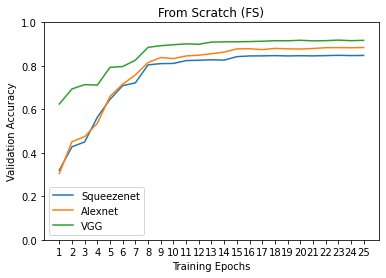

--------------------------------------------------
                    FINETUNING                    
--------------------------------------------------
squeezenet
----------
Epoch 0/24
----------
train Loss: 1.1643 Acc: 0.5989
val Loss: 0.6533 Acc: 0.7796

Epoch 1/24
----------
train Loss: 0.6072 Acc: 0.8048
val Loss: 0.4665 Acc: 0.8462

Epoch 2/24
----------
train Loss: 0.4793 Acc: 0.8501
val Loss: 0.2755 Acc: 0.9101

Epoch 3/24
----------
train Loss: 0.4305 Acc: 0.8576
val Loss: 0.3514 Acc: 0.8849

Epoch 4/24
----------
train Loss: 0.3956 Acc: 0.8699
val Loss: 0.2467 Acc: 0.9181

Epoch 5/24
----------
train Loss: 0.3768 Acc: 0.8777
val Loss: 0.2337 Acc: 0.9194

Epoch 6/24
----------
train Loss: 0.3377 Acc: 0.8858
val Loss: 0.2509 Acc: 0.9227

Epoch 7/24
----------
train Loss: 0.2228 Acc: 0.9264
val Loss: 0.1294 Acc: 0.9583

Epoch 8/24
----------
train Loss: 0.1952 Acc: 0.9373
val Loss: 0.1236 Acc: 0.9586

Epoch 9/24
----------
train Loss: 0.1931 Acc: 0.9361
val Loss: 0.1163 Acc: 0.9

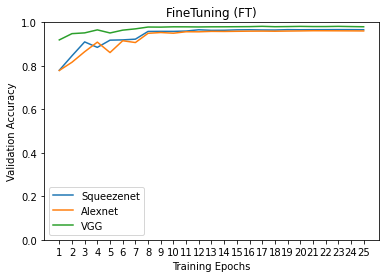

--------------------------------------------------
                FEATURE EXTRACTION                
--------------------------------------------------
squeezenet
----------
Epoch 0/24
----------
train Loss: 0.6677 Acc: 0.7827
val Loss: 0.3458 Acc: 0.8831

Epoch 1/24
----------
train Loss: 0.4863 Acc: 0.8390
val Loss: 0.3032 Acc: 0.8999

Epoch 2/24
----------
train Loss: 0.4700 Acc: 0.8439
val Loss: 0.2969 Acc: 0.9057

Epoch 3/24
----------
train Loss: 0.4592 Acc: 0.8467
val Loss: 0.2825 Acc: 0.9073

Epoch 4/24
----------
train Loss: 0.4369 Acc: 0.8576
val Loss: 0.3045 Acc: 0.8970

Epoch 5/24
----------
train Loss: 0.4183 Acc: 0.8587
val Loss: 0.2449 Acc: 0.9195

Epoch 6/24
----------
train Loss: 0.4107 Acc: 0.8612
val Loss: 0.2832 Acc: 0.9058

Epoch 7/24
----------
train Loss: 0.3674 Acc: 0.8793
val Loss: 0.2402 Acc: 0.9181

Epoch 8/24
----------
train Loss: 0.3712 Acc: 0.8758
val Loss: 0.2282 Acc: 0.9228

Epoch 9/24
----------
train Loss: 0.3543 Acc: 0.8813
val Loss: 0.2249 Acc: 0.9

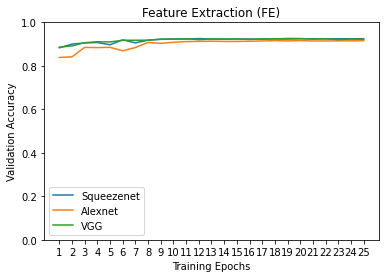

In [41]:
for mode in modes:
    feature_extract, use_pretrained = initialize_mode(mode)
    print('-' * 50)
    if mode == 'FS':
        print('{:^50}'.format('FROM SCRATCH'))
    elif mode == 'FT':
        print('{:^50}'.format('FINETUNING'))
    elif mode == 'FE':
        print('{:^50}'.format('FEATURE EXTRACTION'))
    print('-' * 50)
    
    SQN = []
    AXN = []
    VGG = []
        
    for m in model_list:
        print(m)
        print('-' * 10)
        model_ft, input_size = initialize_model(m, num_classes, feature_extract, use_pretrained)
        model_ft = model_ft.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.005, momentum=0.9)
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
        model_out, val_acc_history, time_elapsed = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)
        total_params = parameters(model_out);
        model_performance = performance(model_out, test_set); 
        print(f'Model: {m}, accuracy: {model_performance}, time: {time_elapsed}, params: {total_params}')
        print('-' * 10)
        if m == 'squeezenet':
            SQN.extend(val_acc_history)
        elif m == 'alexnet':
            AXN.extend(val_acc_history)
        elif m == 'vgg':
            VGG.extend(val_acc_history)
        
        new_row = pd.DataFrame({"Mode": mode, "Model": m, "Accuracy": model_performance, "Parameters": total_params, "Time": time_elapsed}, index=[0])
        results = pd.concat([results, new_row], ignore_index=True)


    if mode == 'FS':
        plot_models(SQN, AXN, VGG, num_epochs, title='From Scratch (FS)')
    
    elif mode == 'FT':
        plot_models(SQN, AXN, VGG, num_epochs, title='FineTuning (FT)')
    
    elif mode == 'FE':
        plot_models(SQN, AXN, VGG, num_epochs, title='Feature Extraction (FE)')

# Results EuroSAT

In [42]:
results

,Mode,Model,Accuracy,Parameters,Time
0,FS,squeezenet,0.84815,727626,8m 57s
1,FS,alexnet,0.88259,57044810,13m 32s
2,FS,vgg,0.91037,128812810,14m 54s
3,FT,squeezenet,0.96741,727626,11m 12s
4,FT,alexnet,0.96241,57044810,11m 3s
5,FT,vgg,0.98278,128812810,14m 28s
6,FE,squeezenet,0.93204,5130,11m 5s
7,FE,alexnet,0.92019,40970,10m 59s
8,FE,vgg,0.92315,40970,11m 12s


In [43]:
print(results.style.to_latex())  

\begin{tabular}{lllrll}
{} & {Mode} & {Model} & {Accuracy} & {Parameters} & {Time} \\
0 & FS & squeezenet & 0.848150 & 727626 & 8m 57s \\
1 & FS & alexnet & 0.882590 & 57044810 & 13m 32s \\
2 & FS & vgg & 0.910370 & 128812810 & 14m 54s \\
3 & FT & squeezenet & 0.967410 & 727626 & 11m 12s \\
4 & FT & alexnet & 0.962410 & 57044810 & 11m 3s \\
5 & FT & vgg & 0.982780 & 128812810 & 14m 28s \\
6 & FE & squeezenet & 0.932040 & 5130 & 11m 5s \\
7 & FE & alexnet & 0.920190 & 40970 & 10m 59s \\
8 & FE & vgg & 0.923150 & 40970 & 11m 12s \\
\end{tabular}



In [44]:
print(results.to_markdown(index=False))  

| Mode   | Model      |   Accuracy |   Parameters | Time    |
|:-------|:-----------|-----------:|-------------:|:--------|
| FS     | squeezenet |    0.84815 |       727626 | 8m 57s  |
| FS     | alexnet    |    0.88259 |     57044810 | 13m 32s |
| FS     | vgg        |    0.91037 |    128812810 | 14m 54s |
| FT     | squeezenet |    0.96741 |       727626 | 11m 12s |
| FT     | alexnet    |    0.96241 |     57044810 | 11m 3s  |
| FT     | vgg        |    0.98278 |    128812810 | 14m 28s |
| FE     | squeezenet |    0.93204 |         5130 | 11m 5s  |
| FE     | alexnet    |    0.92019 |        40970 | 10m 59s |
| FE     | vgg        |    0.92315 |        40970 | 11m 12s |


| Mode   | Model      |   Accuracy |   Parameters | Time    |
|:-------|:-----------|-----------:|-------------:|:--------|
| FS     | squeezenet |    0.84815 |       727626 | 8m 57s  |
| FS     | alexnet    |    0.88259 |     57044810 | 13m 32s |
| FS     | vgg        |    0.91037 |    128812810 | 14m 54s |
| FT     | squeezenet |    0.96741 |       727626 | 11m 12s |
| FT     | alexnet    |    0.96241 |     57044810 | 11m 3s  |
| FT     | vgg        |    0.98278 |    128812810 | 14m 28s |
| FE     | squeezenet |    0.93204 |         5130 | 11m 5s  |
| FE     | alexnet    |    0.92019 |        40970 | 10m 59s |
| FE     | vgg        |    0.92315 |        40970 | 11m 12s |